In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [3]:
# test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [4]:
# Remove duplicates from train dataset
train = train.drop_duplicates()

# Remove duplicates from test dataset
test = test.drop_duplicates()

In [5]:
# Optionally, you can reset index after removing duplicates
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [6]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import PolynomialFeatures


# # 1. Binning or Bucketing Age
# bins = [0, 30, 50, 100]  # Define your bins based on observed correlations or domain knowledge
# labels = ['Young', 'Middle-aged', 'Elderly']
# train['Age_Group'] = pd.cut(train['Age'], bins=bins, labels=labels)

# # 2. Interaction Terms
# train['Age_NumOfProducts'] = train['Age'] * train['NumOfProducts']

# # 3. Polynomial Features
# poly = PolynomialFeatures(degree=2, include_bias=False)
# age_poly = poly.fit_transform(train[['Age']])
# train['Age_Squared'] = age_poly[:, 1]  # Take the squared term

# # 4. Feature Crosses
# train['Age_Gender'] = train['Age_Group'].astype(str) + '_' + train['Gender']

# # 6. Missing Value Imputation
# median_age_exited = train[train['Exited'] == 1]['Age'].median()
# median_age_not_exited = train[train['Exited'] == 0]['Age'].median()
# train.loc[train['Exited'] == 1, 'Age'] = train.loc[train['Exited'] == 1, 'Age'].fillna(median_age_exited)
# train.loc[train['Exited'] == 0, 'Age'] = train.loc[train['Exited'] == 0, 'Age'].fillna(median_age_not_exited)

In [7]:
# import pandas as pd
# from sklearn.preprocessing import PolynomialFeatures

# # 1. Binning or Bucketing Age
# bins = [0, 30, 40, 50, 60, 70, 120]  # Define age bins
# labels = ['0-29', '30-39', '40-49', '50-59', '60-69', '70+']  # Labels for age groups
# test['Age_Group'] = pd.cut(test['Age'], bins=bins, labels=labels)

# # 2. Interaction Terms
# test['Age_NumOfProducts'] = test['Age'] * test['NumOfProducts']

# # 3. Polynomial Features
# poly = PolynomialFeatures(degree=2, include_bias=False)
# age_poly_test = poly.fit_transform(test[['Age']])
# test['Age_Squared'] = age_poly_test[:, 1]  # Take the squared term

# # 4. Feature Crosses
# test['Age_Gender'] = test['Age_Group'].astype(str) + '_' + test['Gender']

# # 5. Missing Value Imputation
# median_age = test['Age'].median()
# test['Age'].fillna(median_age, inplace=True)


In [8]:
def feature(df):
    df["IsBalanceZero"] = df["Balance"]==0
    df['Low_salary'] = df['EstimatedSalary'].apply(lambda x: 1 if x <= 74850 else 0)
    df['Mid_salary'] = df['EstimatedSalary'].apply(lambda x: 1 if (x <= 118528) & (x > 74850) else 0)
    df['High_salary'] = df['EstimatedSalary'].apply(lambda x: 1 if (x > 118528) else 0)
    df['Low_Balance'] = df['Balance'].apply(lambda x: 1 if (x <= 105223.25) & (x != 0) else 0)
    df['Mid_Balance'] = df['Balance'].apply(lambda x: 1 if (x <= 122314) & (x > 105223.25) else 0)
    df['High_Balance'] = df['Balance'].apply(lambda x: 1 if (x > 122314) else 0)
    df['HasCard&Active'] = df["HasCrCard"] * df["IsActiveMember"]
    df["credit_score_cat"] = pd.cut(df["CreditScore"],bins=[0, 450, 650, 750, 850],labels=["very_low", "low", "medium", "high"])
    # Credit Utilization Ratio
    # Credit Utilization Ratio
    df['Credit_Utilization_Ratio'] = df['Balance'] / df['CreditScore']

    # Age Group
    bins = [18, 25, 35, 45, 55, 65, 100]
    labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

    # Balance to Salary Ratio
    df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']

    # Credit Score Category
    bins = [0, 580, 670, 740, 800, np.inf]
    labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
    df['Credit_Score_Category'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)


    # Interaction Score
    df['Interaction_Score'] = df['HasCrCard'] + df['IsActiveMember']

    # Salary Groups
    bins = [0, 30000, 60000, 90000, 120000, np.inf]
    labels = ['0-30k', '30k-60k', '60k-90k', '90k-120k', '120k+']
    df['Salary_Group'] = pd.cut(df['EstimatedSalary'], bins=bins, labels=labels, right=False)


    # Gender Balance
    gender_balance = df.groupby(['Geography', 'Gender']).size() / df.groupby('Geography').size()
    df['Gender_Balance'] = df.apply(lambda x: gender_balance.loc[(x['Geography'], x['Gender'])], axis=1)


    # Inactive Flag
    df['Inactive_Flag'] = ((df['IsActiveMember'] == 0) & (df['HasCrCard'] == 0)).astype(int)

    # Full Utilization Flag
    df['Full_Utilization_Flag'] = ((df['Balance'] == 0) & (df['NumOfProducts'] == 0)).astype(int)

    # Salary-Credit Score Interaction
    df['Salary_Credit_Score_Interaction'] = df['EstimatedSalary'] * df['CreditScore']


In [9]:
feature(train)

In [10]:
feature(test)

In [11]:
train.dtypes

id                                    int64
CustomerId                            int64
Surname                              object
CreditScore                           int64
Geography                            object
Gender                               object
Age                                 float64
Tenure                                int64
Balance                             float64
NumOfProducts                         int64
HasCrCard                           float64
IsActiveMember                      float64
EstimatedSalary                     float64
Exited                                int64
IsBalanceZero                          bool
Low_salary                            int64
Mid_salary                            int64
High_salary                           int64
Low_Balance                           int64
Mid_Balance                           int64
High_Balance                          int64
HasCard&Active                      float64
credit_score_cat                

In [12]:
train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'IsBalanceZero',
       'Low_salary', 'Mid_salary', 'High_salary', 'Low_Balance', 'Mid_Balance',
       'High_Balance', 'HasCard&Active', 'credit_score_cat',
       'Credit_Utilization_Ratio', 'Age_Group', 'Balance_to_Salary_Ratio',
       'Credit_Score_Category', 'Interaction_Score', 'Salary_Group',
       'Gender_Balance', 'Inactive_Flag', 'Full_Utilization_Flag',
       'Salary_Credit_Score_Interaction'],
      dtype='object')

In [13]:
print(train.columns)


Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'IsBalanceZero',
       'Low_salary', 'Mid_salary', 'High_salary', 'Low_Balance', 'Mid_Balance',
       'High_Balance', 'HasCard&Active', 'credit_score_cat',
       'Credit_Utilization_Ratio', 'Age_Group', 'Balance_to_Salary_Ratio',
       'Credit_Score_Category', 'Interaction_Score', 'Salary_Group',
       'Gender_Balance', 'Inactive_Flag', 'Full_Utilization_Flag',
       'Salary_Credit_Score_Interaction'],
      dtype='object')


In [14]:
train.columns = train.columns.str.strip()


In [15]:
print(repr(train.columns))


Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'IsBalanceZero',
       'Low_salary', 'Mid_salary', 'High_salary', 'Low_Balance', 'Mid_Balance',
       'High_Balance', 'HasCard&Active', 'credit_score_cat',
       'Credit_Utilization_Ratio', 'Age_Group', 'Balance_to_Salary_Ratio',
       'Credit_Score_Category', 'Interaction_Score', 'Salary_Group',
       'Gender_Balance', 'Inactive_Flag', 'Full_Utilization_Flag',
       'Salary_Credit_Score_Interaction'],
      dtype='object')


In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, models


train_df = train.drop(columns=['Exited'])

# # Identify numerical and categorical features based on dtypes
# numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
                      'IsActiveMember', 'EstimatedSalary', 
                      'Low_salary', 'Mid_salary', 'High_salary', 'Low_Balance', 'Mid_Balance',
                      'High_Balance', 'HasCard&Active', 'Credit_Utilization_Ratio',
                      'Balance_to_Salary_Ratio', 'Interaction_Score', 'Gender_Balance',
                      'Inactive_Flag', 'Full_Utilization_Flag', 'Salary_Credit_Score_Interaction']

categorical_features = ['Geography', 'Gender', 'Age_Group', 'Credit_Score_Category',
                        'Salary_Group', 'credit_score_cat']
my_cols = categorical_features + numerical_features

print(categorical_features)

X = train_df[my_cols].copy()
y = train['Exited'] 

X_test = test[my_cols].copy()

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_transformer = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('MeanImputer', SimpleImputer())
     ])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

t_X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
t_X_valid = pd.DataFrame(preprocessor.transform(X_valid))

t_X_test = pd.DataFrame(preprocessor.transform(X_test))

print(t_X_train.shape)
print(t_X_valid.shape)
print(t_X_test.shape)

['Geography', 'Gender', 'Age_Group', 'Credit_Score_Category', 'Salary_Group', 'credit_score_cat']
(132027, 47)
(33007, 47)
(110023, 47)


In [17]:
# # Check for infinity or large values in numerical features
# for feature in numerical_features:
#     if X_train[feature].isin([np.inf, -np.inf]).any() or (X_train[feature] > 1e6).any():
#         print("Feature:", feature)
#         print(X_train[X_train[feature].isin([np.inf, -np.inf]) | (X_train[feature] > 1e6)])


In [18]:
# pip install tensorflow

In [19]:
# Define early stopping callback
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)


In [20]:
# Define the neural network architecture
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(t_X_train.shape[1],)),
    layers.BatchNormalization(),  
    layers.Dropout(0.5),  
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [21]:
from tensorflow.keras import layers, models, optimizers

In [22]:
# import matplotlib.pyplot as plt

# dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]  # Define a range of dropout rates to test
# accuracies = []

# for dropout_rate in dropout_rates:
#     # Define the model architecture with the current dropout rate
#     model = models.Sequential([
#         layers.Dense(256, activation='relu', input_shape=(t_X_train.shape[1],)),
#         layers.BatchNormalization(),  
#         layers.Dropout(dropout_rate),  # Use the current dropout rate
#         layers.Dense(128, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dropout(dropout_rate),
#         layers.Dense(64, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dropout(dropout_rate),
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     # Compile the model
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
#     # Fit the model
#     history = model.fit(
#         t_X_train, y_train,
#         validation_data=(t_X_valid, y_valid),
#         batch_size=500,
#         epochs=50,
#         callbacks=[early_stopping],
#         verbose=0  # Set verbose to 0 to suppress output during training
#     )
    
#     # Get the final accuracy on the validation set
#     final_accuracy = history.history['val_accuracy'][-1]
#     accuracies.append(final_accuracy)

# # Plot the results
# plt.plot(dropout_rates, accuracies, marker='o')
# plt.xlabel('Dropout Rate')
# plt.ylabel('Validation Accuracy')
# plt.title('Validation Accuracy vs. Dropout Rate')
# plt.grid(True)
# plt.show()


In [23]:
optimizer = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [24]:
# Fit the model
history = model.fit(
    t_X_train, y_train,
    validation_data=(t_X_valid, y_valid),
    batch_size=800,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
166/166 [==============================] - 5s 17ms/step - loss: 0.6965 - binary_accuracy: 0.6617 - val_loss: 0.4067 - val_binary_accuracy: 0.8411
Epoch 2/50
166/166 [==============================] - 3s 15ms/step - loss: 0.5006 - binary_accuracy: 0.7883 - val_loss: 0.3603 - val_binary_accuracy: 0.8542
Epoch 3/50
166/166 [==============================] - 3s 16ms/step - loss: 0.4301 - binary_accuracy: 0.8266 - val_loss: 0.3458 - val_binary_accuracy: 0.8601
Epoch 4/50
166/166 [==============================] - 3s 17ms/step - loss: 0.3944 - binary_accuracy: 0.8410 - val_loss: 0.3366 - val_binary_accuracy: 0.8601
Epoch 5/50
166/166 [==============================] - 3s 15ms/step - loss: 0.3748 - binary_accuracy: 0.8465 - val_loss: 0.3327 - val_binary_accuracy: 0.8605
Epoch 6/50
166/166 [==============================] - 3s 16ms/step - loss: 0.3648 - binary_accuracy: 0.8500 - val_loss: 0.3288 - val_binary_accuracy: 0.8628
Epoch 7/50
166/166 [==============================] - 3s 1

In [25]:
from sklearn.metrics import classification_report,roc_auc_score

y3_test_pred_CBC=model.predict(t_X_valid)

print("AUC Score",roc_auc_score(y_valid,y3_test_pred_CBC))

1032/1032 [==============================] - 2s 2ms/step
AUC Score 0.8887303256673073


In [40]:
def override_pred(X, pred_y):
    # Assuming X contains the original_exited feature
    # All matching values between train and original data have the target reversed
    # Let's believe this continues and override predictions
    return np.where(X['exited'] == 1, 0, np.where(X['exited'] == 0, 1, pred_y))

In [41]:
y_valid_pred_proba_overridden = override_pred(t_X_valid, y3_test_pred_CBC)

# Calculate ROC AUC score on the overridden predictions
roc_auc_overridden = roc_auc_score(y_valid, y_valid_pred_proba_overridden)
print("Valid Set ROC AUC Score (Overridden):", roc_auc_overridden)


KeyError: 'exited'

Best Validation Loss: 0.3203
Best Validation Accuracy: 0.8664


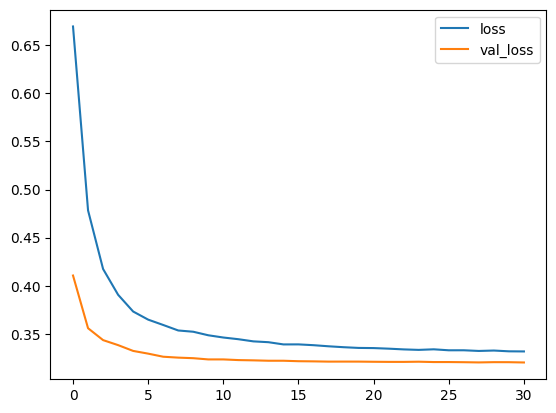

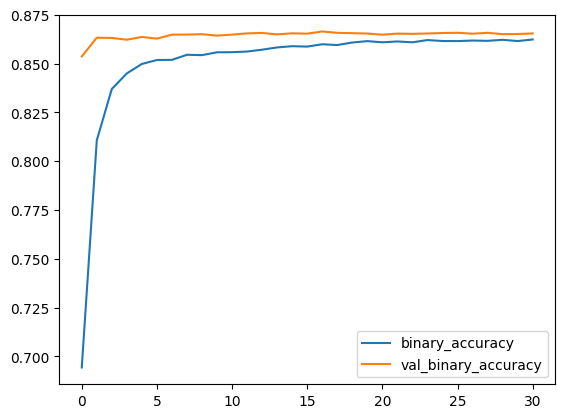

In [21]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [21]:
preds = np.array(model.predict(t_X_test)).reshape(-1)

3439/3439 [==============================] - 6s 2ms/step


In [22]:
output = pd.DataFrame({
    "id": test["id"].to_list(),
    "Exited": preds
})

output

,id,Exited
0,165034,0.020696
1,165035,0.827986
2,165036,0.038283
3,165037,0.350412
4,165038,0.472470
...,...,...
110018,275052,0.053004
110019,275053,0.075836
110020,275054,0.024618
110021,275055,0.166951


In [23]:
output.to_csv('submission.csv', index=False)

In [40]:
# Ideadd_suffixntify numerical and categorical features based on dtypes
numerical_features = test.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = test.select_dtypes(include=['object', 'category']).columns.tolist()


# Preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())  # Standardize features
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [45]:
# Preprocess the data
X_test = test.drop(columns=['Surname'])  

In [47]:
# Fit the preprocessor to the training data before transforming
preprocessor.fit(X_train)

# Now you can transform the test data using the preprocessor
X_test_processed = preprocessor.transform(X_test)


ValueError: A given column is not a column of the dataframe

In [19]:
# # Preprocess the data
# X_test = test.drop(columns=['Surname'])  
               
# # Define categorical and numerical features
# categorical_features = ['Geography', 'Gender']  # Categorical features
# numerical_features = list(X_test.columns.difference(categorical_features))

# # Perform one-hot encoding for categorical features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', OneHotEncoder(), categorical_features)
#     ])

# X_processed = preprocessor.fit_transform(X_test)

# # Include 'id' column in the processed features
# X_with_id = pd.concat([test['id'], pd.DataFrame(X_processed)], axis=1)

In [13]:
test_predictions = model.predict(X_with_id)

3439/3439 [==============================] - 5s 1ms/step


In [ ]:
# # Drop irrelevant columns (if any)
# test.drop(['Surname'], axis=1, inplace=True)

# # One-hot encode categorical variables
# encoder = OneHotEncoder(drop='first', sparse=False)
# encoded_features = encoder.fit_transform(test[['Geography', 'Gender']])
# test_encoded = pd.concat([test.drop(['Geography', 'Gender'], axis=1), pd.DataFrame(encoded_features)], axis=1)

# test_encoded.columns = test_encoded.columns.astype(str)

# # Make predictions on the test set
# test_predictions = model.predict(test_encoded)

In [14]:
test.set_index('id', inplace=True)
test['Exited'] = test_predictions

# Extract the 'DiagPeriodL90D ' column
submission = test['Exited']

# Save the submission to a CSV file
submission.to_csv('submission.csv')

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [8]:
X = train.drop('Exited', axis=1)
y = train['Exited']

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
X.columns = X.columns.astype(str)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

ValueError: could not convert string to float: 'Yobachukwu'

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
4126/4126 [==============================] - 9s 2ms/step - loss: 157.1762 - accuracy: 0.7274 - val_loss: 0.5154 - val_accuracy: 0.7893
Epoch 2/10
4126/4126 [==============================] - 7s 2ms/step - loss: 0.6322 - accuracy: 0.7850 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 3/10
4126/4126 [==============================] - 7s 2ms/step - loss: 0.5505 - accuracy: 0.7881 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 4/10
4126/4126 [==============================] - 7s 2ms/step - loss: 0.5183 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 5/10
4126/4126 [==============================] - 7s 2ms/step - loss: 0.5346 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 6/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5211 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 7/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5244 - accuracy: 0.7882 - val_loss: 0.5149 - val_accurac

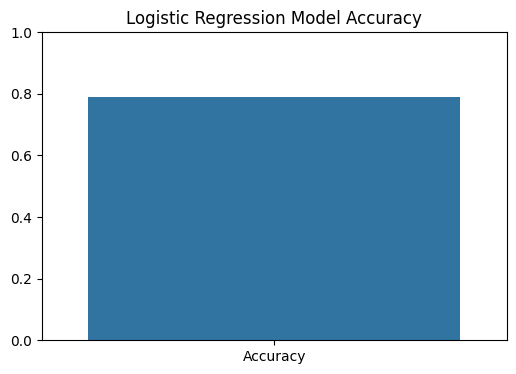

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


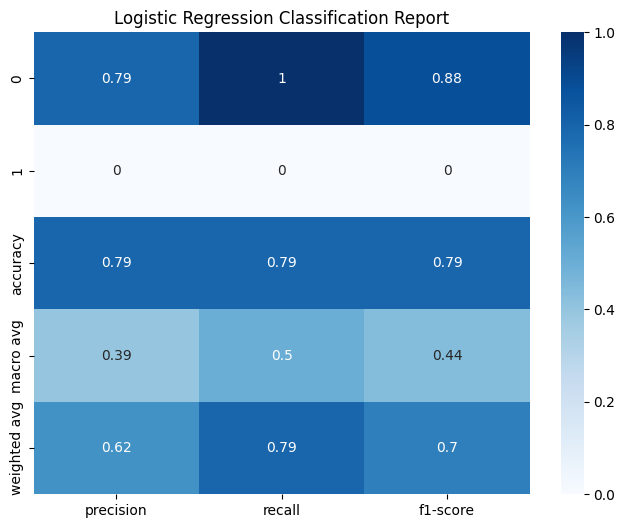

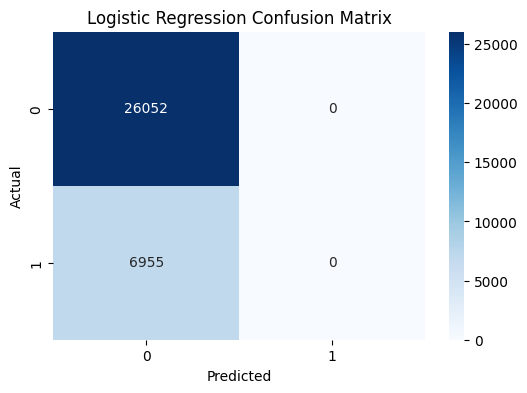

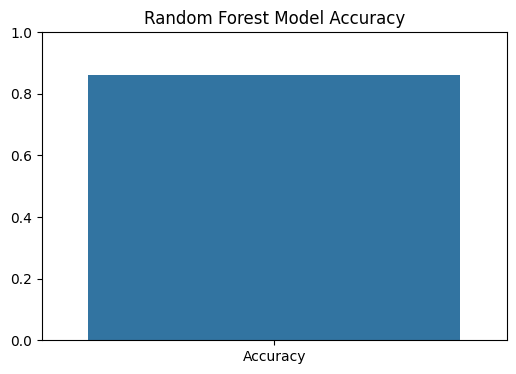

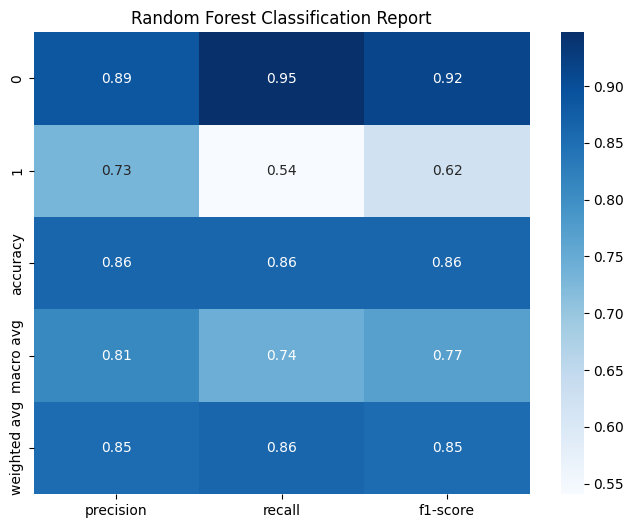

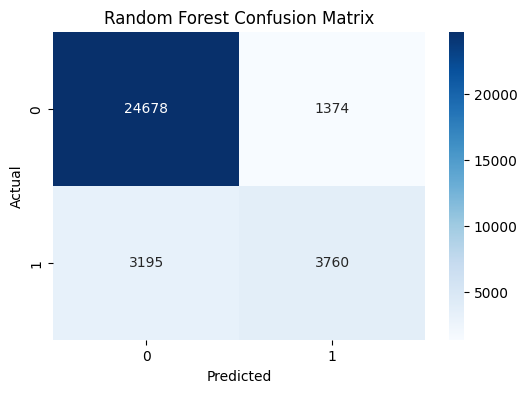

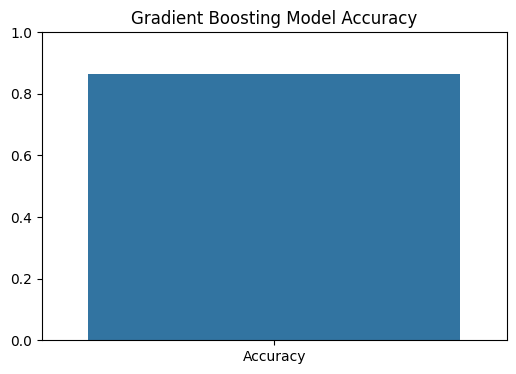

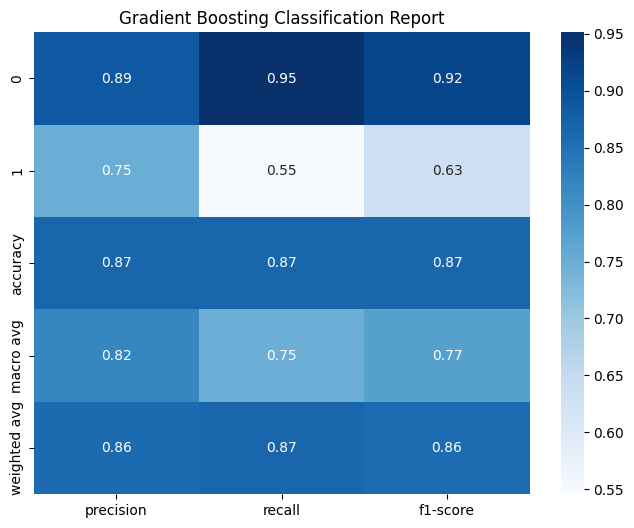

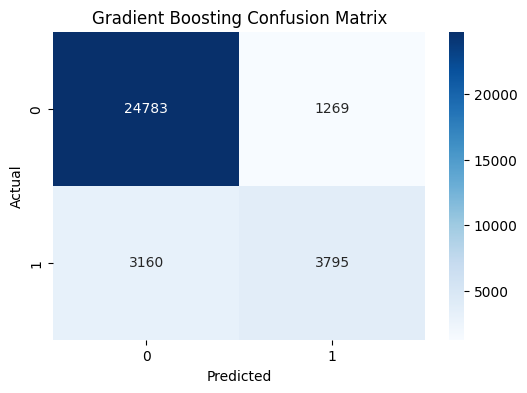

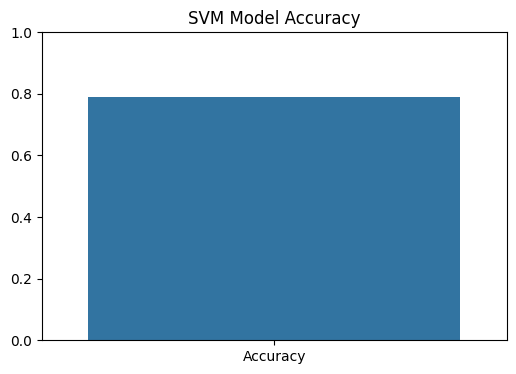

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


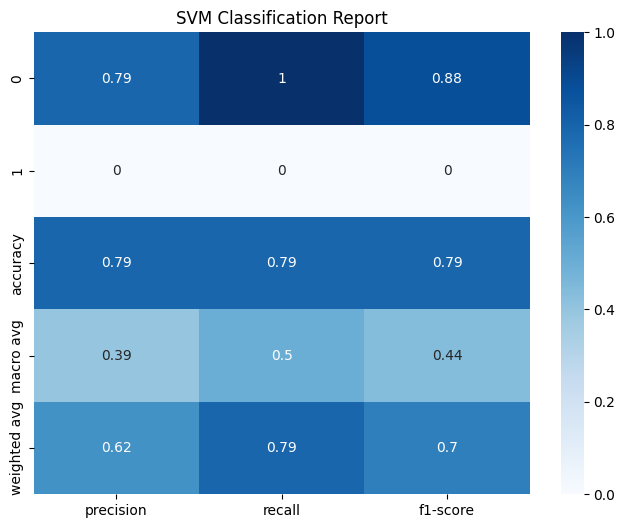

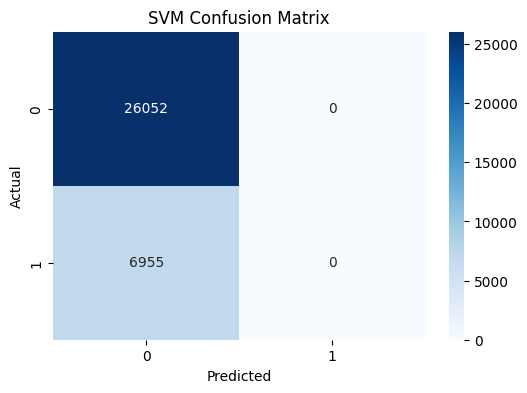

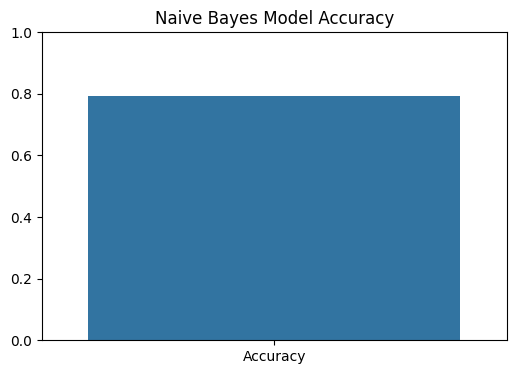

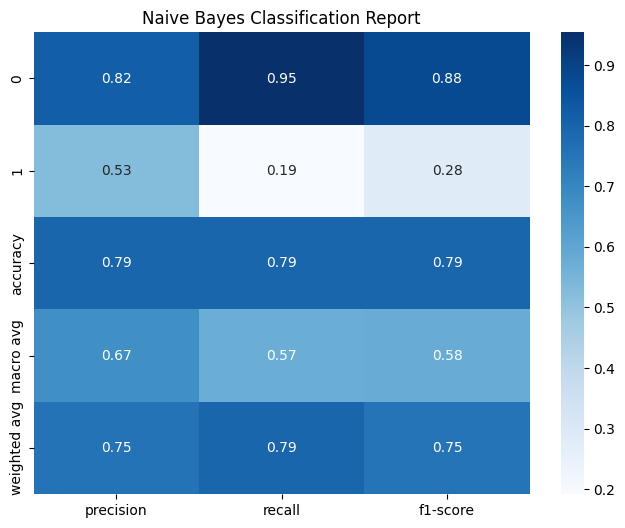

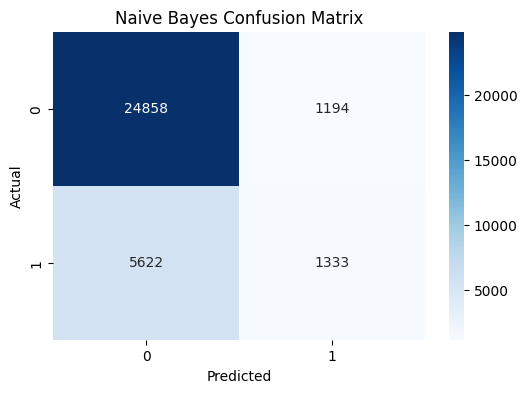

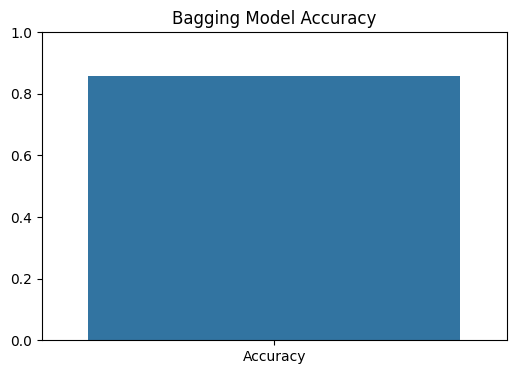

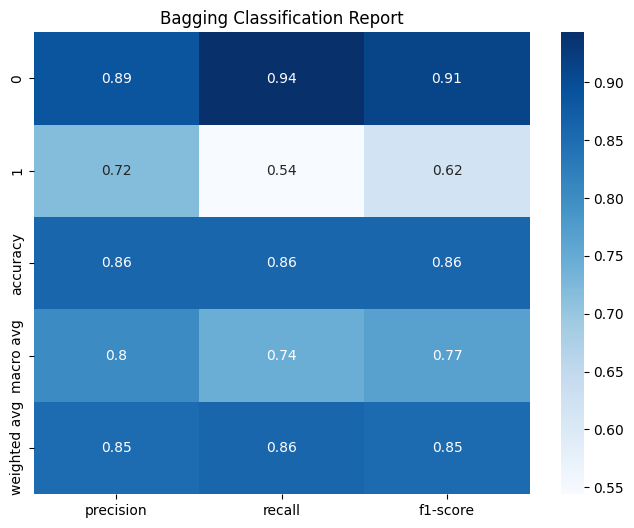

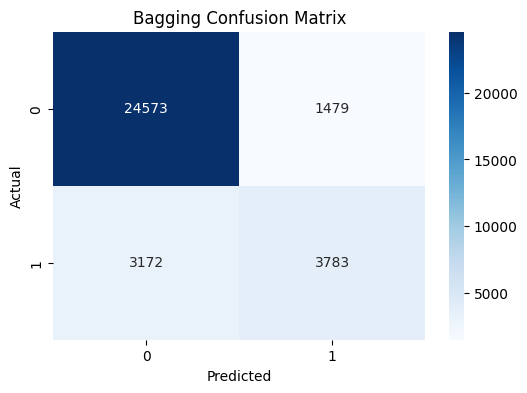

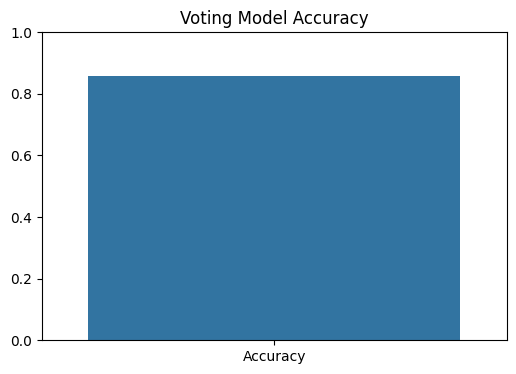

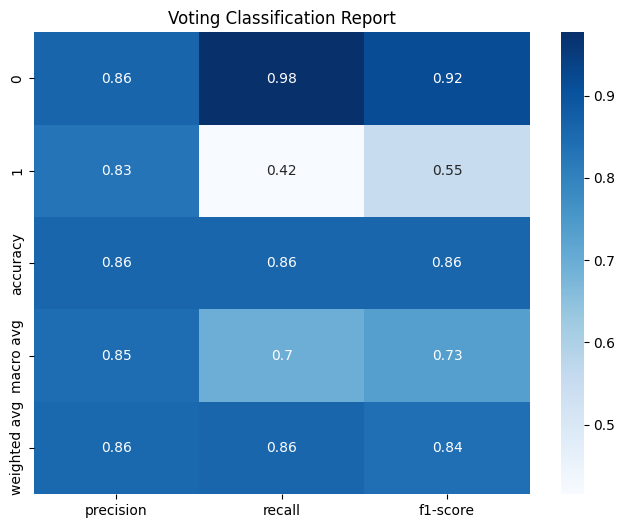

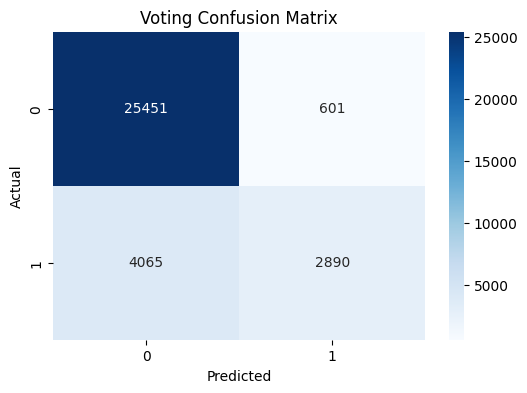

1032/1032 [==============================] - 1s 1ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [9]:
# # Drop irrelevant columns (if any)
# train.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

# # Separate features and target variable
# X = train.drop('Exited', axis=1)
# y = train['Exited']

# # One-hot encode categorical variables
# encoder = OneHotEncoder(drop='first', sparse=False)
# encoded_features = encoder.fit_transform(X[['Geography', 'Gender']])
# X_encoded = pd.concat([X.drop(['Geography', 'Gender'], axis=1), pd.DataFrame(encoded_features)], axis=1)

# X_encoded.columns = X_encoded.columns.astype(str)

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# # Define the neural network model
# def create_nn_model(input_dim):
#     model = Sequential([
#         Dense(64, input_dim=input_dim, activation='relu'),
#         Dropout(0.2),
#         Dense(32, activation='relu'),
#         Dropout(0.2),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Train Logistic Regression model
# lr_model = LogisticRegression()
# lr_model.fit(X_train, y_train)

# # Train Random Forest model
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Train Gradient Boosting model
# gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
# gb_model.fit(X_train, y_train)

# # Train Support Vector Machine (SVM) model
# svm_model = SVC()
# svm_model.fit(X_train, y_train)

# # Train Naive Bayes model
# nb_model = GaussianNB()
# nb_model.fit(X_train, y_train)

# # Train Bagging classifier with Decision Tree base estimator
# bagging_model = BaggingClassifier(n_estimators=100, random_state=42)
# bagging_model.fit(X_train, y_train)

# # Train Voting classifier with Logistic Regression, Random Forest, and Gradient Boosting estimators
# voting_model = VotingClassifier(estimators=[('lr', lr_model), ('rf', rf_model), ('gb', gb_model)], voting='soft')
# voting_model.fit(X_train, y_train)

# # Train Neural Network model
# nn_model = create_nn_model(X_train.shape[1])
# nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# # Evaluate all models
# models = {'Logistic Regression': lr_model, 'Random Forest': rf_model, 'Gradient Boosting': gb_model,
#           'SVM': svm_model, 'Naive Bayes': nb_model, 'Bagging': bagging_model, 'Voting': voting_model,
#           'Neural Network': nn_model}

# for name, model in models.items():
#     y_pred = model.predict(X_test)
#     if hasattr(model, 'predict_proba'):
#         y_pred_proba = model.predict_proba(X_test)[:, 1]
#     else:
#         y_pred_proba = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     # Visualize accuracy
#     plt.figure(figsize=(6, 4))
#     sns.barplot(x=['Accuracy'], y=[accuracy])
#     plt.title(f'{name} Model Accuracy')
#     plt.ylim(0, 1)
#     plt.show()
    
#     # Visualize classification report
#     plt.figure(figsize=(8, 6))
#     report = classification_report(y_test, y_pred, output_dict=True)
#     sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
#     plt.title(f'{name} Classification Report')
#     plt.show()
    
#     # Visualize confusion matrix
#     plt.figure(figsize=(6, 4))
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title(f'{name} Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()

In [10]:
def create_nn_model(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Train Neural Network model
nn_model = create_nn_model(X_train.shape[1])
nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
4126/4126 [==============================] - 9s 2ms/step - loss: 102.4800 - accuracy: 0.7598 - val_loss: 0.5150 - val_accuracy: 0.7893
Epoch 2/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.6281 - accuracy: 0.7875 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 3/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5467 - accuracy: 0.7881 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 4/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5401 - accuracy: 0.7881 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 5/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5183 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 6/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5165 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 7/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5457 - accuracy: 0.7882 - val_loss: 0.5149 - val_accurac

1032/1032 [==============================] - 1s 1ms/step


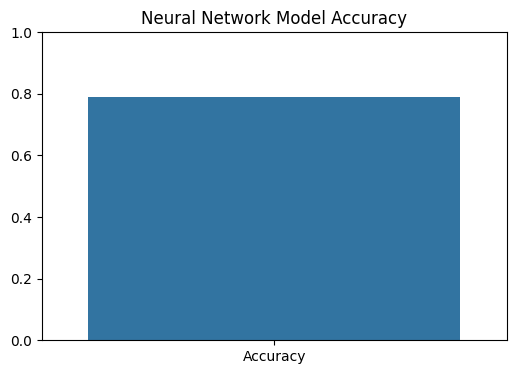

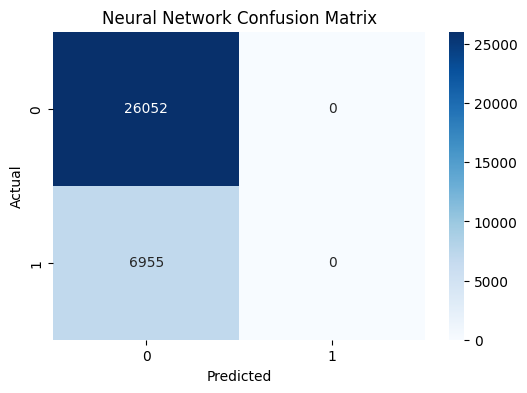

In [14]:
# Evaluate Neural Network model
y_pred_proba_nn = nn_model.predict(X_test)
y_pred_nn = (y_pred_proba_nn >= 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred_nn)

# Visualize accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=['Accuracy'], y=[accuracy_nn])
plt.title('Neural Network Model Accuracy')
plt.ylim(0, 1)
plt.show()

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Epoch 1/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5175 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 2/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5164 - accuracy: 0.7882 - val_loss: 0.5150 - val_accuracy: 0.7893
Epoch 3/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5164 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 4/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5164 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 5/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5313 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 6/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5171 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy: 0.7893
Epoch 7/10
4126/4126 [==============================] - 8s 2ms/step - loss: 0.5185 - accuracy: 0.7882 - val_loss: 0.5149 - val_accuracy:

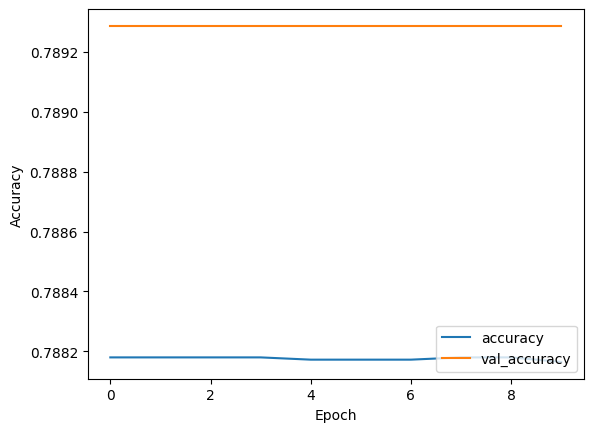

Class Distribution:
Exited
0    0.78818
1    0.21182
Name: proportion, dtype: float64


In [15]:
# Check model training
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Inspect data imbalance
class_distribution = y_train.value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)

# Review model architecture and hyperparameters
# Experiment with different architectures, optimizers, learning rates, etc.

# Debug preprocessing steps
# Check feature scaling, encoding, handling of missing values, etc.
# Inspect preprocessed data if necessary
